In [7]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095451 sha256=b9ab9df07661ea44dd053dc75060eba4eacd8a4a8f4186a4a5b64f6a6ba759fd
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [8]:
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import SVD

def laplace_noise(beta):
    return np.random.laplace(0, beta, 1)[0]

def clamp(x, min, max):
    if x > max:
        x = max
    elif x < min:
        x = min
    return x

def train_recommender_system(data, n_factors, learning_rate, reg_param, num_iterations, e_max, epsilon):

    def input_perturbation(data, trainset):

        min_rating = min([r[2] for r in data.raw_ratings])
        max_rating = max([r[2] for r in data.raw_ratings])
        sensitivity = max_rating - min_rating
        beta = sensitivity / epsilon

        noisy_user_ratings = {}
        user_ratings = trainset.ur
        for k, v in user_ratings.items():
            noisy_ratings = []
            for rating in v:
                user_id = k
                item_id = rating[0]
                noisy_rating = rating[1] + laplace_noise(beta)
                noisy_rating = clamp(noisy_rating, 1.0, 5.0)
                noisy_ratings.append((item_id, noisy_rating))
            noisy_user_ratings[k] = noisy_ratings
        trainset.ur = noisy_user_ratings

        noisy_item_ratings = {}
        item_ratings = trainset.ir
        for k, v in item_ratings.items():
            noisy_ratings = []
            for rating in v:
                user_id = rating[0]
                user_ratings = noisy_user_ratings[user_id]
                noisy_rating = [nr for iid, nr in user_ratings if iid == k][0]
                noisy_ratings.append((user_id, noisy_rating))
            noisy_item_ratings[k] = noisy_ratings
        trainset.ir = noisy_item_ratings

        return trainset

    class DPSVD(SVD):
        def __init__(self, n_factors=100, epsilon=1.0):
            super().__init__(n_factors=n_factors)
            self.epsilon = epsilon

        def fit(self, trainset):
            super().fit(trainset)

            # Get the user-item matrix
            P = self.pu
            Q = self.qi

            # Apply the Laplace Mechanism to the gradients
            # sensitivity = max([r[2] for r in self.trainset.all_ratings()]) - min(r[2] for r in self.trainset.all_ratings())
            sensitivity = 4.0

            # Perform SGD iterations
            for k in range(1, num_iterations + 1):
                for uid, iid, r_ui in self.trainset.all_ratings():
                    beta = k * sensitivity / self.epsilon
                    # Compute the gradient
                    prediction = self.predict(uid, iid).est
                    error = r_ui - prediction + laplace_noise(beta)
                    error = clamp(error, min=-e_max, max=e_max)
                    Q[iid] += learning_rate * (error * P[uid] - reg_param * Q[iid])
                    P[uid] += learning_rate * (error * Q[iid] - reg_param * P[uid])

            self.pu = P
            self.qi = Q

    # Perform cross-validation manually
    kf = KFold(n_splits=5, random_state=42)

    # Lists to store RMSE values for each fold
    rmse_values = []

    for trainset, testset in kf.split(data):
        trainset = input_perturbation(data, trainset)

        # Define the DPSVD algorithm with specified parameters
        algo = DPSVD(n_factors=n_factors, epsilon=epsilon)

        # Train the algorithm on the training set
        algo.fit(trainset)

        # Test the algorithm on the testing set
        predictions = algo.test(testset)

        # Compute and print Root Mean Squared Error (RMSE)
        rmse = accuracy.rmse(predictions)
        rmse_values.append(rmse)

    # Compute average RMSE across folds
    avg_rmse = sum(rmse_values) / len(rmse_values)

    print("Avg. Training RMSE:", avg_rmse)

    return algo, avg_rmse

RMSE: 1.1995
RMSE: 1.2078
RMSE: 1.1988
RMSE: 1.2018
RMSE: 1.2035
Avg. Training RMSE: 1.2022848249325475

Test RMSE:
RMSE: 1.2098

Baseline RMSE:
RMSE: 0.9463

RMSE: 1.1274
RMSE: 1.1185
RMSE: 1.1213
RMSE: 1.1060
RMSE: 1.1263
Avg. Training RMSE: 1.1198891563994056

Test RMSE:
RMSE: 1.1831

Baseline RMSE:
RMSE: 0.9446

RMSE: 1.0698
RMSE: 1.0692
RMSE: 1.0736
RMSE: 1.0646
RMSE: 1.0664
Avg. Training RMSE: 1.068711469705677

Test RMSE:
RMSE: 1.1615

Baseline RMSE:
RMSE: 0.9464

RMSE: 1.0347
RMSE: 1.0346
RMSE: 1.0330
RMSE: 1.0215
RMSE: 1.0349
Avg. Training RMSE: 1.0317551604639175

Test RMSE:
RMSE: 1.1530

Baseline RMSE:
RMSE: 0.9449

RMSE: 1.0138
RMSE: 1.0163
RMSE: 1.0125
RMSE: 1.0031
RMSE: 1.0103
Avg. Training RMSE: 1.0112191891788256

Test RMSE:
RMSE: 1.1491

Baseline RMSE:
RMSE: 0.9454

RMSE: 0.9979
RMSE: 0.9986
RMSE: 0.9910
RMSE: 0.9878
RMSE: 0.9966
Avg. Training RMSE: 0.9943688951589513

Test RMSE:
RMSE: 1.1436

Baseline RMSE:
RMSE: 0.9457

RMSE: 0.9821
RMSE: 0.9847
RMSE: 0.9824
RMSE: 0.

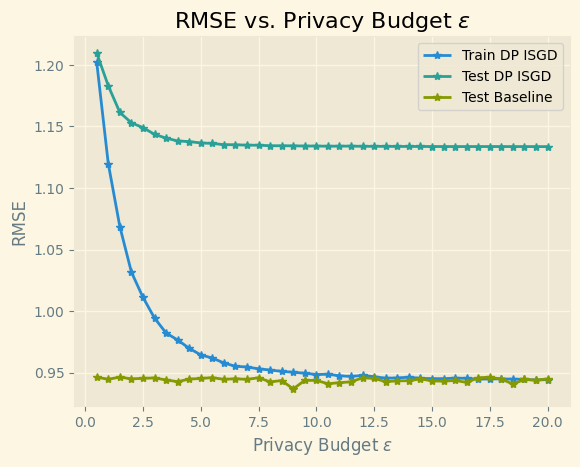

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from surprise import Reader
plt.style.use("Solarize_Light2")

def baseline_model(trainset, testset, n_factors):
    # Define the SVD algorithm with 100 latent factors
    algo = SVD(n_factors=n_factors)

    # Train the algorithm on the training set
    algo.fit(trainset)

    # Test the algorithm on the testing set
    print('Baseline RMSE:')
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    print('')

    # Compute and print Root Mean Squared Error (RMSE)
    return rmse

data = Dataset.load_builtin('ml-100k')

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Create a new Reader object to define the rating scale
reader = Reader(rating_scale=(1.0, 5.0))
# Get the user-item ratings from the Trainset
user_item_ratings = pd.DataFrame([(uid, iid, r) for (uid, iid, r) in trainset.all_ratings()])
# Create a new Dataset object using the extracted ratings
tdataset = Dataset.load_from_df(user_item_ratings, reader)

# Define the range of epsilon values
epsilons = np.arange(0.5, 20.5, 0.5)

# Initialize lists to store epsilon and RMSE values
epsilon_values = []
train_rmse_values = []
test_rmse_values = []
baseline_rmse_values = []

for epsilon in epsilons:

    epsilon_values.append(epsilon)

    # Call the function with the current epsilon value
    algo, train_rmse = train_recommender_system(data=tdataset, n_factors=3, learning_rate=0.001, reg_param=0.06, num_iterations=5, e_max=2.0, epsilon=epsilon)
    train_rmse_values.append(train_rmse)

    predictions = algo.test(testset)

    print('\nTest RMSE:')
    test_rmse = accuracy.rmse(predictions)
    print('')
    test_rmse_values.append(test_rmse)

    baseline_rmse = baseline_model(trainset, testset, n_factors=3)
    baseline_rmse_values.append(baseline_rmse)

# Plot RMSE vs epsilon
plt.plot(epsilon_values, train_rmse_values, '*-', label='Train DP ISGD')
plt.plot(epsilon_values, test_rmse_values, '*-', label='Test DP ISGD')
plt.plot(epsilon_values, baseline_rmse_values, '*-', label='Test Baseline')
plt.xlabel('Privacy Budget $\epsilon$')
plt.ylabel('RMSE')
plt.title('RMSE vs. Privacy Budget $\epsilon$')
plt.legend()
plt.show()